In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import product
from multiprocessing import Pool
from os import cpu_count
cores = cpu_count() # get the number of CPUs

Last time: we had just used KNN to predict wine color. It was successful, with accuracy around 99%.

In [2]:
df = pd.read_csv('wine.csv')
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']
target = ['color']

x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.2)
x_tr,x_va,y_tr,y_va = train_test_split(x_tr,y_tr,
                                       test_size = 0.5)
scaler = StandardScaler()
scaler.fit(x_tr)
x_tr_n = pd.DataFrame(scaler.transform(x_tr))
x_tr_n.columns = features
x_tr_n.index = x_tr.index
x_va_n = pd.DataFrame(scaler.transform(x_va))
x_va_n.columns = features
x_va_n.index = x_va.index

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(scaler.transform(x_tr),y_tr)
knn.score(scaler.transform(x_va),y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9930742593305117

We checked correlates with color.

In [4]:
df.corr()['color'].loc[features,].sort_values(key = lambda x:1-abs(x))

total sulfur dioxide   -0.700357
volatile acidity        0.653036
chlorides               0.512678
sulphates               0.487218
fixed acidity           0.486740
free sulfur dioxide    -0.471644
density                 0.390645
residual sugar         -0.348821
pH                      0.329129
citric acid            -0.187397
quality                -0.119323
alcohol                -0.032970
Name: color, dtype: float64

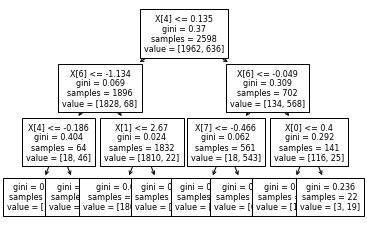

In [15]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
tr = DecisionTreeClassifier(max_depth = 3)
tr.fit(scaler.transform(x_tr),y_tr)
plot_tree(tr,fontsize = 8);

In [6]:
x_tr.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3110            8.8              0.23         0.74             3.2      0.042   
2477            6.2              0.16         0.54             1.4      0.126   
6131            5.8              0.12         0.21             1.3      0.056   
3095            6.7              0.62         0.24             1.1      0.039   
5337            5.6              0.26         0.18             1.4      0.034   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
3110                 15.0                 126.0  0.99340  3.02       0.51   
2477                 37.0                 110.0  0.99320  3.23       0.37   
6131                 35.0                 121.0  0.99080  3.32       0.33   
3095                  6.0                  62.0  0.99340  3.41       0.32   
5337                 18.0                 135.0  0.99174  3.32       0.35   

      alcohol  quality  
3110     11.2        6  
2477      8.9        6  
6131     11.4        6  
3095     10.4        5  
5337     10.2        6

We examined pairwise scatterplots of the features, trying to observe the extent to which two features separate the colors. X[0] and X[4] are most interesting, after that either X[1] or X[7].

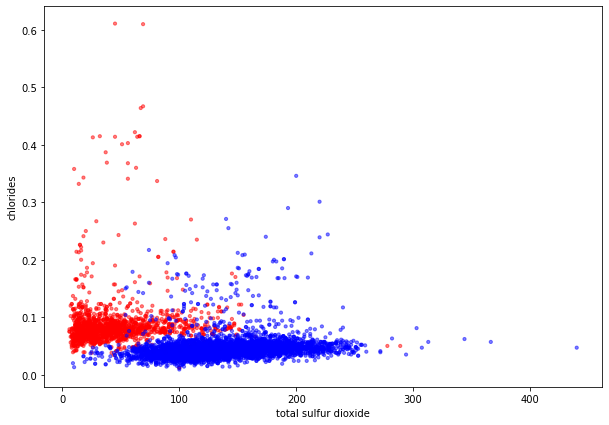

In [8]:
colors = {1:'red',0:'blue'}
scatter_feats = []
scatter_feats.append('total sulfur dioxide') 
# scatter_feats.append('volatile acidity')
scatter_feats.append('chlorides')
# scatter_feats.append('sulphates')
# scatter_feats.append('fixed acidity')
# scatter_feats.append('free sulfur dioxide')
fig,ax = plt.subplots(figsize = (10,7))
ax.scatter(df[scatter_feats[0]],
            df[scatter_feats[1]],
            color = df.color.map(colors),
           alpha = 0.5,s = 10)
ax.set_ylabel(f'{scatter_feats[1]}')
ax.set_xlabel(f'{scatter_feats[0]}');

If two dimensions largely separate the wine colors, more dimensions may separate them to a greater extent. Three is about as many as we can effectively visualize.

The following plot was substantially adapted from [here](https://plotly.com/python/3d-charts/).

In [18]:
# !pip3 install dash

In [22]:
f1 = 'total sulfur dioxide'
f2 = 'chlorides'
f3 = 'density'

from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('wines filtered by volatile acidity'),
    dcc.Graph(id="graph"),
    html.P('volatile acidity:'),
    dcc.RangeSlider(
        id='range-slider',
        min=0, max=1.6, step=0.05,
        marks={0: '0', 2.5: '2.5'},
        value=[0.5, 2]
    ),
])

@app.callback(
    Output("graph", "figure"), 
    Input("range-slider", "value"))
def update_bar_chart(slider_range):
    low, high = slider_range
    mask = (df['volatile acidity'] > low) & (df['volatile acidity'] < high)

    fig = px.scatter_3d(df[mask], 
        x=f1, y=f2, z=f3,
        color="color", color_continuous_scale=px.colors.sequential.Bluered)
    return fig

app.run_server()

### k means

Now we'll discuss clustering. This is different than the models we have studied so far in that clustering algorithms are examples of **unsupervised learning**. This means: we don't have training data where we feed examples of inputs and right answers to the algorithm to condition it to make good predictions.

k means is a clustering algorithm. There are many implementations of k means; I will demonstrate one algorithm on the whiteboard.

In [23]:
# synthetic classification dataset
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [33]:
data = []
N = 1000
for i in range(N):
    data.append((np.random.normal(6,1),np.random.normal(7,1)))
for i in range(N):
    data.append((np.random.normal(5,1),np.random.normal(1,1.5)))
for i in range(N):
    x = np.random.normal(1,.25)
    data.append((x,5+x*np.random.normal(5,1)))
for i in range(N):
    x = np.random.normal(1,0.1)
    data.append((x,-x*np.random.normal(5,1)))
df = pd.DataFrame(data,columns = ['x','y'])
# assign cluster number to each row
df['cluster'] = np.array(range(len(df)))//N
# shuffle the dataframe
new_idx = list(range(len(df)))
np.random.shuffle(new_idx)
df.index = new_idx
df = df.sort_index()
df.head(10)

x          y  cluster
0  4.089995   2.442678        1
1  5.734264   1.127327        1
2  4.378272   2.585072        1
3  0.980423  -3.324664        3
4  1.041574  10.513863        2
5  1.057819  -5.777018        3
6  0.970566   9.547133        2
7  5.550166   6.316923        0
8  0.796468  -4.049168        3
9  3.953777   7.226259        0

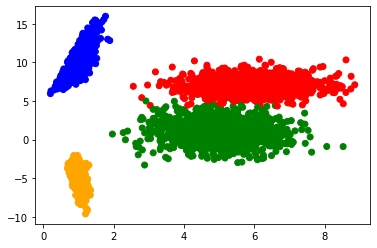

In [34]:
plt.scatter(df.x,df.y,c = df['cluster'].map({0:'r',1:'g',2:'b',3:'orange'}));

Let's use sklearn's KMeans to identify clusters within our data. We will plot the data colored by cluster as identified by KMeans.

In [26]:
from sklearn.cluster import KMeans

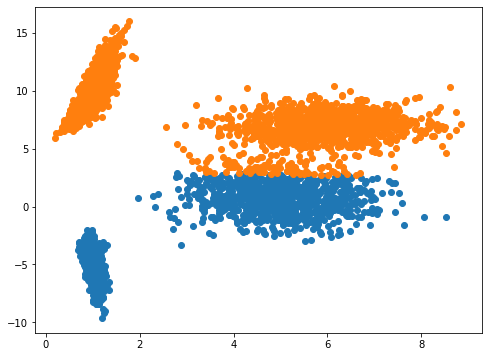

In [36]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df[['x','y']])
df['pred'] = kmeans.predict(df[['x','y']])
fig,ax = plt.subplots(figsize = (8,6))
for i in range(n_clusters):
    ax.scatter(df[df.pred == i].x,df[df.pred == i].y)

Discovering the proper value of k does not necessarily involve examining a graph (and this would be hard to do if we were dealing with higher-dimensional data!). Instead, we can look at the model's inertia_ value, which returns the sum of squared distances of each point from its assigned mean. Of course, this value can only get lower as the number of means increases. What we're looking for is an "elbow" in the graph.

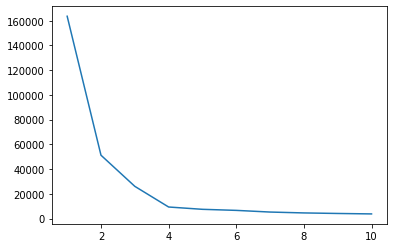

In [37]:
inertias = []
for n_clusters in range(1,11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(df[['x','y']])
    inertias.append(kmeans.inertia_)
plt.plot(range(1,11),inertias);

After k=4, the improvements are quite modest. This makes it likely that there are four clusters in the data.

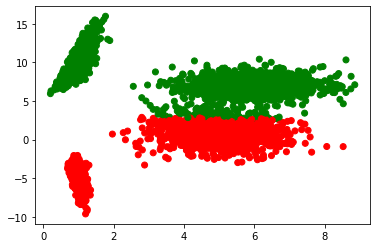

In [38]:
plt.scatter(df.x,df.y,c = df.pred.map({0:'r',1:'g'}));

How do we measure accuracy vs our preidentified clusters? The answer is: we don't. If you have preidentified clusters, we might as well be using a supervised learning method. However, it is not terribly difficult to adapt clustering to a supervised approach. How would that look? Term project?

We can use k-means to try to discover clusters in the wine data. It would be interesting to see if setting k=2 clusters results in classification by color.

In [40]:
df = pd.read_csv('wine.csv')
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']

scaler.fit(df[features])
x_n = scaler.transform(df[features])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x_n)
preds = kmeans.predict(x_n)

In [41]:
# examine the predictions vs y_va. Do we notice anything?
pd.DataFrame({'actual':df['color'],'pred': preds})

actual  pred
0          1     0
1          1     0
2          1     0
3          1     0
4          1     0
...      ...   ...
6492       0     1
6493       0     1
6494       0     1
6495       0     1
6496       0     1

[6497 rows x 2 columns]

In [42]:
# computing the number of incorrect predictions
sum((preds-df['color'])**2)

6378

Since 1 and 0 were assigned arbitrarily, it's possible 1 was assigned to white and 0 to red. Indeed, we're off significantly more than half the time, which means the opposite guess is right more than half the time. Remember, we're just discovering a pattern with unsupervised learning, and there is no training set here!

In [44]:
sum((preds-(1-df['color']))**2)

119

In [45]:
119/len(df)

0.018316145913498536

So, the clusters naturally discovered among the features (with no information at all about color) naturally group the wines into red and white, with 119 or <2% exceptions!

It could be interesting to examine the exceptions by e.g. looking at the differences between the statistics in a color overall vs within the exceptions.

In [46]:
df_exceptions = df[[bool(_) for _ in preds-(1-df['color'])]]

In [48]:
df_exceptions[df_exceptions['color']==1].describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count      25.000000         25.000000    25.000000       25.000000   
mean        6.716000          0.309200     0.370000        4.330000   
std         1.161422          0.113575     0.210614        4.217375   
min         5.000000          0.160000     0.020000        0.900000   
25%         5.900000          0.210000     0.250000        1.700000   
50%         6.700000          0.300000     0.370000        2.100000   
75%         7.100000          0.390000     0.500000        8.300000   
max        10.000000          0.540000     0.780000       13.900000   

       chlorides  free sulfur dioxide  total sulfur dioxide    density  \
count  25.000000            25.000000             25.000000  25.000000   
mean    0.055400            31.620000            114.800000   0.993294   
std     0.017851            14.600428             61.789967   0.002169   
min     0.012000             6.000000             18.000000   0.990070   
25%     0.049000            23.000000             88.000000   0.991200   
50%     0.054000            36.000000            100.000000   0.993280   
75%     0.068000            37.500000            135.000000   0.995200   
max     0.083000            72.000000            289.000000   0.997210   

              pH  sulphates    alcohol    quality  color  
count  25.000000  25.000000  25.000000  25.000000   25.0  
mean    3.250800   0.552800  11.634000   6.200000    1.0  
std     0.184863   0.106086   1.177278   0.912871    0.0  
min     2.890000   0.390000   9.200000   4.000000    1.0  
25%     3.120000   0.500000  11.200000   6.000000    1.0  
50%     3.300000   0.540000  11.800000   6.000000    1.0  
75%     3.350000   0.590000  12.300000   7.000000    1.0  
max     3.540000   0.820000  14.000000   8.000000    1.0

In [49]:
df[df.color ==1].describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality   color  
count  1599.000000  1599.000000  1599.000000  1599.000000  1599.0  
mean      3.311113     0.658149    10.422983     5.636023     1.0  
std       0.154386     0.169507     1.065668     0.807569     0.0  
min       2.740000     0.330000     8.400000     3.000000     1.0  
25%       3.210000     0.550000     9.500000     5.000000     1.0  
50%       3.310000     0.620000    10.200000     6.000000     1.0  
75%       3.400000     0.730000    11.100000     6.000000     1.0  
max       4.010000     2.000000    14.900000     8.000000     1.0

Note that scaling does have an impact on the accuracy here: we'll try without scaling first.

In [50]:
x = df[features]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x)
preds = kmeans.predict(x)
print(sum((preds-df['color'])**2))
print(sum((preds-(1-df['color']))**2))

5104
1393


It would be even more interesting to know if specifying further clusters would identify the types of wine (e.g. malbec, cabernet, ...) and/or the regions of origin. It's a shame this dataset does not include those details!

In [51]:
inertias = []
for n_clusters in range(1,20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(x_n)
    inertias.append(kmeans.inertia_)

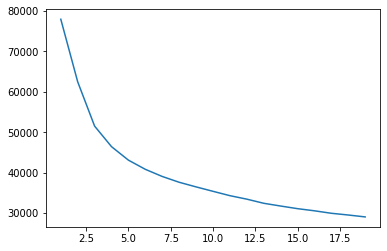

In [52]:
plt.plot(range(1,20),inertias);

There are at least 3 major clusters.

There are very many approaches to clustering beyond basic kmeans. You should review some of them [here](https://scikit-learn.org/stable/modules/clustering.html).